In [2]:
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install transformers datasets pandas seaborn matplotlib wordcloud scikit-learn

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import torch

In [5]:
# Initialize widgets state
widgets.Widget.widgets = {}

In [1]:
!pip install datasets==2.14.5 fsspec==2023.9.2 --upgrade

INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install datasets==2.14.5 and fsspec==2023.9.2 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested fsspec==2023.9.2
    datasets 2.14.5 depends on fsspec<2023.9.0 and >=2023.1.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [6]:
# Load the emotion tweet dataset
# Load the emotion tweet dataset with proper widget handling
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dataset = load_dataset("dair-ai/emotion")

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
df = pd.DataFrame(dataset["train"])
label_names = dataset["train"].features["label"].names
df["label_name"] = df["label"].apply(lambda x: label_names[x])


**Explore the dataset **


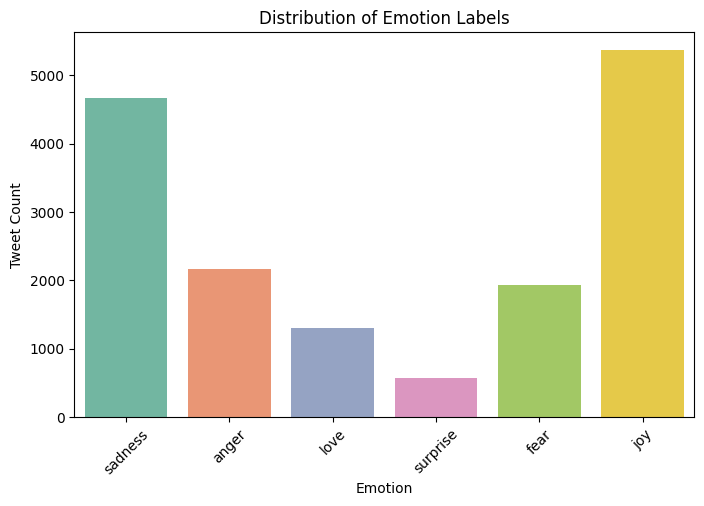

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="label_name", palette="Set2")
plt.title("Distribution of Emotion Labels")
plt.xlabel("Emotion")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.show()


In [9]:
#  Sample Tweets per Emotion
for emotion in label_names:
    print(f"\n--- {emotion.upper()} ---")
    sample_texts = df[df["label_name"] == emotion]["text"].sample(2, random_state=1).values
    for text in sample_texts:
        print(f"• {text}")



--- SADNESS ---
• i still feel guilty to this day for taking a spot
• i feel so empty and cold inside

--- JOY ---
• i was feeling eager to press on
• im actually feeling a little smug

--- LOVE ---
• i met a really cute girl who i feel kind of fond for today and normally girls are really complex to me but i can just be myself around her
• i wake up i realize that my panty is wet and i feel very horny

--- ANGER ---
• i plot that makes the reader feel like he is with owen morgan during his dangerous undertaking
• i feel i really wronged commodore

--- FEAR ---
• i feel especially vulnerable to being treated as a second class citizen
• i forgive myself that i have accepted and allowed myself to feel terrified when i can not move myself or speak or scream in sleep paralysis

--- SURPRISE ---
• i feel so weird about it
• im not sure if anyone else will feel these but i was pleasantly surprised by my read of the first and second book


In [10]:
# Preprocessing for BERT with widget state handling
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    encoded_dataset = dataset.map(tokenize, batched=True)
    encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [11]:
train_dataset = encoded_dataset["train"]
val_dataset = encoded_dataset["validation"]
test_dataset = encoded_dataset["test"]


In [12]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments

In [14]:
training_args= TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs",
     fp16=True,                     # ← enable mixed precision
    gradient_accumulation_steps=2, # ← accumulate grads to simulate batch=32
)


In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


In [16]:
from transformers import DataCollatorWithPadding

# Auto-pad all batches using the tokenizer's pad token
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [20]:
# train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yossifreda500 (yossifreda500-corelia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.126300
1000,0.099300
1500,0.061800


TrainOutput(global_step=1500, training_loss=0.0957966168721517, metrics={'train_runtime': 307.9571, 'train_samples_per_second': 155.866, 'train_steps_per_second': 4.871, 'total_flos': 2055637166515776.0, 'train_loss': 0.0957966168721517, 'epoch': 3.0})

In [21]:
results = trainer.evaluate(test_dataset)
print(f"\n Accuracy on Test Set Data: {results['eval_accuracy']:.2f}")



 Accuracy on Test Set Data: 0.93
